In [1]:
%matplotlib inline

https://github.com/alexgkendall/SegNet-Tutorial

https://github.com/mostafaizz/camvid

In [137]:
import glob
from PIL import Image
import numpy as np
import bcolz
import threading
import matplotlib.pyplot as plt
import re
import random

In [6]:
img_sz = (480, 360)
def open_image(fn):
    return np.array(Image.open(fn).resize(img_sz, Image.NEAREST))
fnames = glob.glob('CamVid/train/*.png')
img_train = np.stack([open_image(fn) for fn in fnames])
fnames = glob.glob('CamVid/trainannot/*.png')
label_train = np.stack([open_image(fn) for fn in fnames])

fnames = glob.glob('CamVid/val/*.png')
img_val = np.stack([open_image(fn) for fn in fnames])
fnames = glob.glob('CamVid/valannot/*.png')
label_val = np.stack([open_image(fn) for fn in fnames])

fnames = glob.glob('CamVid/test/*.png')
img_test = np.stack([open_image(fn) for fn in fnames])
fnames = glob.glob('CamVid/testannot/*.png')
label_test = np.stack([open_image(fn) for fn in fnames])

In [44]:
fnames = glob.glob('CamVid/train/*.png')
img = Image.open(fnames[12]).resize(img_sz, Image.NEAREST)
np.array(img).shape

(360, 480, 3)

In [7]:
img_train.shape, label_train.shape

((367, 360, 480, 3), (367, 360, 480))

In [8]:
img_val.shape, label_val.shape

((101, 360, 480, 3), (101, 360, 480))

In [9]:
img_test.shape, label_test.shape

((233, 360, 480, 3), (233, 360, 480))

In [11]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname): 
    return bcolz.open(fname)[:]

In [13]:
save_array('img_train.bc', img_train)
save_array('label_train.bc', label_train)
save_array('img_val.bc', img_val)
save_array('label_val.bc', label_val)
save_array('img_test.bc', img_test)
save_array('label_test.bc', label_test)

In [46]:
img_train = load_array('img_train.bc')
label_train = load_array('label_train.bc')
img_val = load_array('img_val.bc')
label_val = load_array('label_val.bc')
img_test = load_array('img_test.bc')
label_test = load_array('label_test.bc')

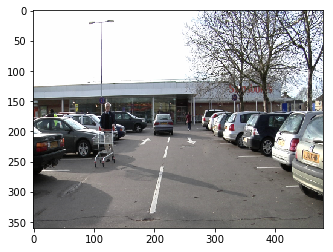

In [57]:
img = img_train[0]*0.3+0.4
plt.imshow(img.astype(np.uint8))

In [49]:
img_train = img_train.astype(np.float32)
img_train-=0.4
img_train/=0.3
img_val = img_val.astype(np.float32)
img_val-=0.4
img_val/=0.3
img_test = img_test.astype(np.float32)
img_test-=0.4
img_test/=0.3

In [20]:
label_train = label_train.astype(np.float32)
label_val = label_val.astype(np.float32)
label_test = label_test.astype(np.float32)

## preprocessing

In [21]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [24]:
bi = BatchIndices(10,3)
[next(bi) for o in range(5)]

[array([0, 1, 2]),
 array([3, 4, 5]),
 array([6, 7, 8]),
 array([9]),
 array([0, 1, 2])]

In [25]:
bi = BatchIndices(10,3,True)
[next(bi) for o in range(5)]

[array([3, 7, 1]),
 array([4, 9, 0]),
 array([5, 2, 6]),
 array([8]),
 array([6, 7, 9])]

In [26]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

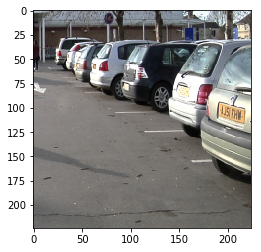

In [59]:
sg = segm_generator(img_train, label_train, 4, train=False)
b_img, b_label = next(sg)
plt.imshow((b_img[0]*0.3+0.4).astype(np.uint8));

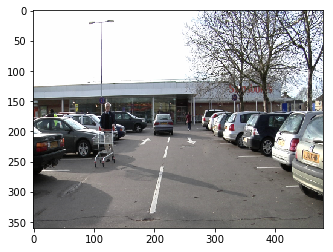

In [60]:
plt.imshow((img_train[0]*0.3+0.4).astype(np.uint8));

In [61]:
b_img.shape, b_label.shape

((4, 224, 224, 3), (4, 50176, 1))

## convert labels

In [75]:
prog = re.compile('(\d+ \d+ \d+)[ \t]+(\w+)')
def parse_code(l):
    result = prog.match(l)
    a, b = result.groups()
    return tuple(int(o) for o in a.split(' ')), b

In [76]:
label_codes,label_names = zip(*[
    parse_code(l) for l in open("label_colors.txt")])

In [77]:
label_codes,label_names = list(label_codes),list(label_names)

In [78]:
list(zip(label_codes,label_names))[:5]

[((64, 128, 64), 'Animal'),
 ((192, 0, 128), 'Archway'),
 ((0, 128, 192), 'Bicyclist'),
 ((0, 128, 64), 'Bridge'),
 ((128, 0, 0), 'Building')]

In [79]:
code2id = {v:k for k,v in enumerate(label_codes)}

In [80]:
failed_code = len(label_codes)+1

In [81]:
label_codes.append((0,0,0))
label_names.append('unk')

In [99]:
def conv_one_label(label): 
    res = np.zeros(label.shape+(3,), 'uint8')
    for j in range(res.shape[0]): 
        for k in range(res.shape[1]):
            res[j,k] = label_codes[label[j,k]]
    return res

In [83]:
from concurrent.futures import ProcessPoolExecutor

In [97]:
def conv_all_labels(labels):
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, labels))

In [100]:
%time label_train_int = conv_all_labels(label_train)

CPU times: user 392 ms, sys: 216 ms, total: 608 ms
Wall time: 41.7 s


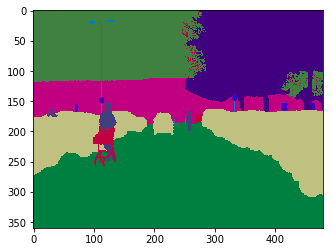

In [102]:
plt.imshow(label_train_int[0])

## The Tiramisu

In [131]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l2
from keras import backend as K
K.set_image_data_format('channels_last')

In [113]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return concatenate(xs, axis=-1)

In [107]:
def conv(x, nf, sz, wd, p, stride=1):
    x = Conv2D(nf, (sz, sz), 
               kernel_initializer='he_uniform', 
               padding='same', 
               strides=stride, 
               kernel_regularizer=l2(wd))(x)
    return dropout(x,p)
def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [108]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [109]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [110]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [123]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, (3, 3), 
                           kernel_initializer='he_uniform', 
                           padding='same', 
                           strides=2, 
                           kernel_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [112]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [114]:
def reverse(a): return list(reversed(a))

In [115]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

## train

In [116]:
input_shape = (224,224,3)

In [117]:
img_input = Input(shape=input_shape)

In [124]:
x = create_tiramisu(12, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [125]:
model = Model(img_input, x)

In [127]:
model.output_shape

(None, 50176, 12)

In [128]:
gen = segm_generator(img_train, label_train, 3, train=True)

In [133]:
gen_val = segm_generator(img_val, label_val, 3, train=False)

In [129]:
gen_test = segm_generator(img_test, label_test, 3, train=False)

In [132]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=RMSprop(1e-3), metrics=["accuracy"])

In [138]:
model.fit_generator(gen, len(label_train)//3, 100, verbose=2, 
                    validation_data=gen_val, validation_steps=len(label_val)//3)

Epoch 1/100
206s - loss: 10.9807 - acc: 0.3385 - val_loss: 15.6269 - val_acc: 0.0518
Epoch 2/100
170s - loss: 10.1820 - acc: 0.3837 - val_loss: 14.6126 - val_acc: 0.1119
Epoch 3/100
170s - loss: 9.9967 - acc: 0.3942 - val_loss: 14.4274 - val_acc: 0.1164
Epoch 4/100
169s - loss: 9.8035 - acc: 0.4016 - val_loss: 14.9249 - val_acc: 0.0898
Epoch 5/100
169s - loss: 9.7105 - acc: 0.4080 - val_loss: 14.1741 - val_acc: 0.1328
Epoch 6/100
169s - loss: 9.5547 - acc: 0.4179 - val_loss: 14.6392 - val_acc: 0.1065
Epoch 7/100
169s - loss: 9.2119 - acc: 0.4407 - val_loss: 13.8537 - val_acc: 0.1544
Epoch 8/100
169s - loss: 8.8697 - acc: 0.4626 - val_loss: 14.1402 - val_acc: 0.1368
Epoch 9/100
169s - loss: 9.0914 - acc: 0.4491 - val_loss: 14.2741 - val_acc: 0.1283
Epoch 10/100
169s - loss: 8.8421 - acc: 0.4648 - val_loss: 14.0555 - val_acc: 0.1417
Epoch 11/100
169s - loss: 8.6386 - acc: 0.4776 - val_loss: 13.7287 - val_acc: 0.1630
Epoch 12/100
169s - loss: 8.5683 - acc: 0.4822 - val_loss: 14.2305 - val

170s - loss: 0.7400 - acc: 0.8260 - val_loss: 0.9128 - val_acc: 0.7817
Epoch 99/100
170s - loss: 0.7430 - acc: 0.8263 - val_loss: 0.8978 - val_acc: 0.7835
Epoch 100/100
170s - loss: 0.7424 - acc: 0.8255 - val_loss: 0.9231 - val_acc: 0.7229


In [139]:
model.optimizer=RMSprop(1e-5, decay=1-0.9995)
model.fit_generator(gen, len(label_train)//3, 200, verbose=1, 
                    validation_data=gen_val, validation_steps=len(label_val)//3)

Epoch 1/200
122/122 [==============================] - 170s - loss: 0.7726 - acc: 0.8172 - val_loss: 0.9284 - val_acc: 0.7367
Epoch 2/200
122/122 [==============================] - 170s - loss: 0.7429 - acc: 0.8246 - val_loss: 1.0110 - val_acc: 0.7692
Epoch 3/200
122/122 [==============================] - 170s - loss: 0.7279 - acc: 0.8273 - val_loss: 2.2333 - val_acc: 0.4595
Epoch 4/200
122/122 [==============================] - 170s - loss: 0.7467 - acc: 0.8187 - val_loss: 0.7955 - val_acc: 0.7989
Epoch 5/200
122/122 [==============================] - 169s - loss: 0.7401 - acc: 0.8250 - val_loss: 0.8176 - val_acc: 0.7868
Epoch 6/200
122/122 [==============================] - 169s - loss: 0.7689 - acc: 0.8158 - val_loss: 0.7783 - val_acc: 0.7951
Epoch 7/200
122/122 [==============================] - 169s - loss: 0.7355 - acc: 0.8218 - val_loss: 0.7659 - val_acc: 0.7895
Epoch 8/200
122/122 [==============================] - 169s - loss: 0.7427 - acc: 0.8208 - val_loss: 0.7651 - val_acc:

122/122 [==============================] - 170s - loss: 0.5285 - acc: 0.8703 - val_loss: 1.3252 - val_acc: 0.7384
Epoch 130/200
122/122 [==============================] - 170s - loss: 0.5587 - acc: 0.8628 - val_loss: 0.5487 - val_acc: 0.8765
Epoch 131/200
122/122 [==============================] - 169s - loss: 0.5375 - acc: 0.8676 - val_loss: 0.7385 - val_acc: 0.8131
Epoch 132/200
122/122 [==============================] - 169s - loss: 0.5306 - acc: 0.8719 - val_loss: 0.4862 - val_acc: 0.8714
Epoch 133/200
122/122 [==============================] - 169s - loss: 0.5677 - acc: 0.8607 - val_loss: 0.5038 - val_acc: 0.8761
Epoch 134/200
122/122 [==============================] - 169s - loss: 0.5466 - acc: 0.8651 - val_loss: 0.9000 - val_acc: 0.7914
Epoch 135/200
122/122 [==============================] - 169s - loss: 0.5314 - acc: 0.8686 - val_loss: 0.5736 - val_acc: 0.8489
Epoch 136/200
122/122 [==============================] - 169s - loss: 0.5366 - acc: 0.8657 - val_loss: 0.5781 - val_ac

In [140]:
model.save_weights('model.h5')

## results

In [141]:
preds = model.predict_generator(gen_test, len(label_test)//3)
preds = np.argmax(preds, axis=-1)
preds = preds.reshape((-1,224,224))

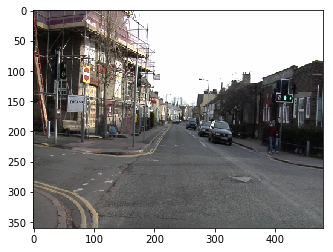

In [143]:
plt.imshow((img_test[0]*0.3+0.4).astype(np.uint8))

In [144]:
label_test_int = conv_all_labels(label_test)

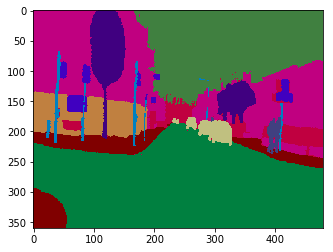

In [145]:
plt.imshow(label_test_int[0])

In [147]:
preds_int = conv_all_labels(preds)

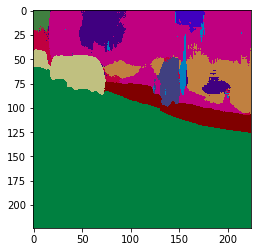

In [148]:
plt.imshow(preds_int[0])